# setup

In [74]:
import os

if os.getcwd().split('/')[-1] == 'notebooks':
    os.chdir('..')

In [75]:
import pathlib
import matplotlib.pyplot as plt
import lasio
import numpy as np
import tensorflow as tf
import pandas as pd
import math

from scipy import signal
from segysak.segy import get_segy_texthead, segy_header_scan, segy_header_scrape, segy_loader
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from scipy.linalg import toeplitz
from numpy.linalg import lstsq

In [76]:
#Ordem de inputs da funcao: 1 - profundidade, 2- curva de poco que deseja filtrar parta a escala sismica, 3 -dado sismico 3D
#4- ponto mais raso em profundidade (equivalente ao corte inicial do dado sismico),
#5- ponto mais profundo(equivalente ao corte final do dado sismico)
def escala_sismica(depth,curva_poco,dado_sismico,depth_point1,depth_point2): 
    wells=[]
    
    wells.append(np.array([depth,curva_poco]).T)
    #print(wells)
    npocos = 1
    avgParam = 1 #parameter used for
    upperLimit = depth_point2#intersection of points
    lowerLimit = depth_point1
    columns = [] 
    jumpvec =[]
    inivec = np.zeros(npocos)
    endvec = np.zeros(npocos)
    dzi = np.zeros(npocos)
    indw = 0
    
    for well in wells:
        depthX = 0
        dzi[indw] = well[3,0] -well[2,0]
        ini, end = -1, -1
        for i in range(well.shape[0]):
            if well[i, 0] >= lowerLimit and well[i, 0] <= upperLimit:
                depthX += 1
                if ini == -1:
                    ini = i
            elif ini != -1:
                end = i-1
                break
        if end == -1:# in case is the whole well
            end = well.shape[0]-1
        jump = (depthX-1)/(dado_sismico.shape[2])
        
        inivec[indw] = ini
        endvec[indw] = end
        indw +=1
    
        jumpvec.append([math.floor(jump)])
        columns.append([math.floor(ini + j*jump) for j in range(dado_sismico.shape[2]+1)])
    
    jumpvec =np.array(jumpvec)

    wellsF =[]
    for i in range(len(wells)):
        auxWell = []
        #print(np.shape(inivec))
    
        # cria dados de poco com filtro
        auxWellF = []
    
        a = math.floor(inivec[i])

        #vetores com dados originais do poco selecionados na faixa de 200m
        auxcurva = wells[i][math.floor(inivec[i]):math.floor(endvec[i]),1]
        
        # escala dos dados sismicos em metros
        lb = 5
        #escala do poco i e'  dada por   (200/(endvec[i] - inivec[i]))
        ep =(200/(endvec[i] - inivec[i]))

        Timepoco  = np.arange(np.shape(auxcurva)[0])

        vpmedio = 4.865042027693202 #km/s
        dti = 2 * dzi[i]  / (1000 * vpmedio)   # dzi[i]  passo de profundidade poco poco i em metros
        Timepoco = Timepoco * dti
        nfiltp  = 3
        #60 na linha abaixo  corresponde 60 Hertz que define o corte no filtro (frequencias acima de 60 são cortadas)
        cutofffrp =  2 * 60 * dti
        #print(dti,cutofffrp)
        bp, ap = signal.butter(nfiltp, cutofffrp)
        curvafilt = signal.filtfilt(bp, ap, np.squeeze(auxcurva))
        
        for j in range((dado_sismico.shape[2])):

            curvaiF = curvafilt[j*jumpvec[i]]

            auxWellF.append([curvaiF])
        
        j = (dado_sismico.shape[2]) 
        curvaiF = curvafilt[j*jumpvec[i]-1]
        auxWellF.append([curvaiF])
    
        wellsF.append(auxWellF)

        wellsF[i] = np.array(auxWellF)

    wells = np.array(wellsF)
    return wells[0,:,0,0]

In [77]:
def wavl(ref, seis, proj = False):
    # proj = False
    # ref é a refletividade da wavelet
    R = toeplitz(ref)

    clf = linear_model.Ridge(alpha=0.005, fit_intercept=False)
    clf.fit(R, seis) # seis é o array de traço sísmico

    if proj: # se você quiser projetar a wavelet para que ela tenha uma amplitude não-zero numa area reduzida proj = True
        wavelet_size = 20 # samples
        opProj = np.zeros((seis.size, seis.size))

        opProj[:wavelet_size, :wavelet_size] = np.eye(wavelet_size)

        op  = np.dot(R, opProj)
        wav = lstsq(op, seis, rcond = None)[0]
    else:
        wav = clf.coef_
    synth = R.dot(wav) # traço sintético gerado pela wavelet
    cur_cor = np.corrcoef(seis, synth)[0][1] # correlação do traço sintético com o traço sísmico real
    print(cur_cor)
    return wav, synth

In [78]:
def cross(Rpp, wvlt):
    R = toeplitz(Rpp)
    synth = R.dot(wvlt)
    return synth

In [79]:
def RC_fwd_model_ia(ia1, ia2):
    Rpp = (ia2 - ia1) / (ia2 + ia1)
    return Rpp

# poço

In [80]:
def porosity_calc(rho_b, rho_ma, rho_f):
    rho_n = np.array(rho_b)
    phi_calc = np.zeros(rho_n.size)
    for i in range(rho_n.size):
        phi_calc[i] = ((rho_n[i] - rho_ma) / (rho_f-rho_ma))*100

    return phi_calc

In [81]:
# well1 = lasio.read('7buz12rjs_editadas.las')
# well2 = lasio.read('7-buz-14da-rjs_curvas_basicas.las')
well3 = lasio.read('data/dados/7buz23rjs.las')
# well4 = lasio.read('7-buz-25-rjs_curvas_basicas.las')
well5 = lasio.read('data/dados/7-buz-29-rjs.las')
# well6 = lasio.read('7-buz-31d-rjs_curvas_basicas.las')
# well7 = lasio.read('8-BUZ-21D-RJS_editadas.las')
well8 = lasio.read('data/dados/8-buz-26-rjs.las')
well9 = lasio.read('data/dados/8buz28da.las')
# well10 = lasio.read('8-buz-32da-rjs_curvas_basicas.las')
# well11 = lasio.read('8buz15rjs_edit.las')
well12 = lasio.read('data/dados/8buz20rjs.las')
# well13 = lasio.read('3-BRSA-1184-RJS-las.las')
well14 = lasio.read('data/dados/7-buz-10-rjs.las')
# well15 = lasio.read('7-BUZ-30-RJS-las.las')
# well16 = lasio.read('8-BUZ-9-RJS-las.las')
# well20 = lasio.read('9-BRSA-1191-RJS-las.las') #converter nphi para porcentagem
# well18 = lasio.read('9-BUZ-4-RJS-las.las')
# well19 = lasio.read('9-BUZ-8-RJS-las.las')

##
# well17 = lasio.read('9-BRSA-1197-RJS-las.las') #Utilizar para gerar figura, converter nphi para porcentagem
well18 = lasio.read('data/dados/3-brsa-1053-rjs.las')

In [82]:
well3_df = well3.df().dropna(how = 'any', axis=0)
well5_df = well5.df().dropna(how = 'any', axis=0)
well8_df = well8.df().dropna(how = 'any', axis=0)
well9_df = well9.df().dropna(how = 'any', axis=0)
well12_df = well12.df().dropna(how = 'any', axis=0)
well14_df = well14.df().dropna(how = 'any', axis=0)
well18_df = well18.df().dropna(how = 'any', axis=0)

In [83]:
data3 = well3_df
res3 = np.array(data3['BRRESP'])[+150:]
rho3 = np.array(data3['BRDENS'])[+150:]
dtp3 = np.array(data3['BRDTP'])[+150:]
dts3 = np.array(data3['BRDTS'])[+150:]
phi3 = np.array(data3['BRNEUT'])[+150:]
gr3 = np.array(data3['BRGR'])[+150:]
z3 = data3.index[+150:]

vp3 = (10**3/dtp3)*0.3048 #km/s
vs3 = (10**3/dts3)*0.3048 #km/s

phi_den3 = porosity_calc(rho3,2.8,1.05)

twt3 = np.array(data3['TWT'])[+150:]
dpt3 = np.array(data3['DEPT'])[+150:]

In [108]:
data3

,TVD,TWT,BRCALI,BRDENS,BRDTP,BRDTS,BRGR,BRNEUT,BRRESC,BRRESM,...,BRTTI,CHECKSHOT_TZ,CHECKSHOT_VINT,SYNTH__CHECKSHOT_VINT,CHECKSHOT_ZT,DEPT,SYNTH__PIMP,SYNTH__SEISMIC,SYNTH__SEISMIC_REFLECTIVITY,SYNTH__SIMP
DEPTH,,,,,,,,,,,,,,,,,,,,,
5357.4696,5332.4696,4784.0671,16.220219,2.2826,60.561680,98.80780,23.008418,31.981120,2.720670,1748.495200,...,-0.000098,4784.0671,1009.9749,1009.9749,5332.4696,5357.4695,12053.948,-7.266744,-0.024651,7387.5258
5357.6220,5332.6220,4784.3688,16.468592,2.3981,64.617691,111.14514,18.015785,35.266107,2.898401,-154.218250,...,0.013137,4784.3688,1009.9749,1009.9749,5332.6220,5357.6219,11341.855,-7.153894,-0.019561,6594.4597
5357.7744,5332.7744,4784.6706,16.172335,2.4037,67.701649,119.66703,13.852585,37.031688,2.229449,120.996530,...,0.973539,4784.6706,1009.9749,1009.9749,5332.7744,5357.7743,10463.145,-7.005246,-0.014680,5919.4845
5357.9268,5332.9268,4784.9724,15.713594,2.3230,65.966676,121.69464,11.349094,36.252721,2.317974,153.816500,...,0.016091,4784.9724,1009.9749,1009.9749,5332.9268,5357.9267,10795.451,-6.821148,-0.001045,5851.5360
5358.0792,5333.0792,4785.2742,15.296435,2.3371,65.867738,120.06035,11.744761,33.418478,2.414343,184.033570,...,-0.002668,4785.2742,1009.9749,1009.9749,5333.0792,5358.0791,11124.986,-6.599408,-0.002225,6103.5912
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5849.7216,5824.7216,4968.5605,12.241851,2.7443,60.830467,104.72553,67.292889,2.132252,10.330685,62.834491,...,0.000000,4968.5605,4612.9243,4612.9243,5824.7216,5849.7216,13764.872,-6.745516,0.003559,7995.4531
5849.8740,5824.8740,4968.6266,12.232103,2.7471,59.848518,103.09010,57.024166,1.720517,10.551088,102.093990,...,0.000000,4968.6266,4612.9243,4612.9243,5824.8740,5849.8740,14011.995,-6.769598,0.000112,8134.6351
5850.0264,5825.0264,4968.6927,12.233937,2.7515,59.496401,102.70614,52.441404,1.513990,10.490002,83.485524,...,0.000000,4968.6927,4612.9243,4612.9243,5825.0264,5850.0264,14119.121,-6.792282,0.009435,8179.0359


In [109]:
data5 = well5_df
res5 = np.array(data5['BRRESP'])[+150:]
rho5 = np.array(data5['BRDENS'])[+150:]
dtp5 = np.array(data5['BRDTP'])[+150:]
phi5 = np.array(data5['BRNEUT'])[+150:]
gr5 = np.array(data5['BRGR'])[+150:]
z5 = data5.index[+150:]

vp5 = (10**3/dtp5)*0.3048 #km/s

phi_den5 = porosity_calc(rho5,2.8,1.05)

twt5 = np.array(data5['TWT'])[+150:]
# dpt5 = np.array(data5['DEPT'])[+150:]
dpt5 = np.array(data5['TVD'])[+150:]

In [85]:
data8 = well8_df
res8 = np.array(data8['BRRESP'])[+14200:]
rho8 = np.array(data8['BRDENS'])[+14200:]
dtp8 = np.array(data8['BRDTP'])[+14200:]
phi8 = np.array(data8['BRNEUT'])[+14200:]
gr8 = np.array(data8['BRGR'])[+14200:]
z8 = data8.index[+14200:]

vp8 = (10**3/dtp8)*0.3048 #km/s

phi_den8 = porosity_calc(rho8,2.8,1.05)

twt8 = np.array(data8['TWT'])[+14200:]

In [86]:
data9 = well9_df
res9 = np.array(data9['BRRESP'])
rho9 = np.array(data9['BRDENS'])
dtp9 = np.array(data9['BRDTP'])
phi9 = np.array(data9['BRNEUT'])
gr9 = np.array(data9['BRGR'])
z9 = data9.index

vp9 = (10**3/dtp9)*0.3048 #km/s

phi_den9 = porosity_calc(rho9,2.8,1.05)

twt9 = np.array(data9['TWT'])

In [87]:
data12 = well12_df
res12 = np.array(data12['BRRESP'])
rho12 = np.array(data12['BRDENS'])
dtp12 = np.array(data12['BRDTP'])
phi12 = np.array(data12['BRNEUT'])
gr12 = np.array(data12['BRGR'])
z12 = data12.index

vp12 = (10**3/dtp12)*0.3048 #km/s

phi_den12 = porosity_calc(rho12,2.8,1.05)

twt12 = np.array(data12['TWT'])

In [88]:
data14 = well14_df
# res14 = np.array(data14['RT90'])[+500:-500]
# rho14 = np.array(data14['RHOB'])[+500:-500]
# dtp14 = np.array(data14['DT'])[+500:-500]
# phi14 = np.array(data14['NPHI'])[+500:-500]
# gr14 = np.array(data14['GR'])[+500:-500]
# z14 = data14.index[+500:-500]
res14 = np.array(data14['RT90'])
rho14 = np.array(data14['RHOB'])
dtp14 = np.array(data14['DT'])
phi14 = np.array(data14['NPHI'])
gr14 = np.array(data14['GR'])
z14 = data14.index

vp14 = (10**3/dtp14)*0.3048 #km/s

phi_den14 = porosity_calc(rho14,2.8,1.05)

twt14 = np.array(data14['TWT'])

In [89]:
data18 = well18_df
res18 = np.array(data18['BRRESP'])
rho18 = np.array(data18['BRDENS'])
dtp18 = np.array(data18['BRDTP'])
phi18 = np.array(data18['BRNEUT'])*1e2
gr18 = np.array(data18['BRGR'])
z18 = data18.index

vp18 = (10**3/dtp18)*0.3048 #km/s

phi_den18 = porosity_calc(rho18,2.8,1.05)

twt18 = np.array(data18['TWT'])

# sismica

In [90]:
V3D_path = pathlib.Path("data/dados/buzios_corte_tempo.sgy")
# V3D_path = pathlib.Path("../datasets/ffb/Area_Teste_Interpretabilidade_10-04-24.sgy")
print("3D", V3D_path, V3D_path.exists())

3D data/dados/buzios_corte_tempo.sgy True


In [91]:
scan = segy_header_scan(V3D_path)
scan

100%|██████████| 1.00k/1.00k [00:00<00:00, 22.9k traces/s]


,byte_loc,count,mean,std,min,25%,50%,75%,max
TRACE_SEQUENCE_LINE,1,1000.0,500.500,288.819436,1.0,250.75,500.5,750.25,1000.0
TRACE_SEQUENCE_FILE,5,1000.0,500.500,288.819436,1.0,250.75,500.5,750.25,1000.0
FieldRecord,9,1000.0,4004.713,0.699371,4004.0,4004.00,4005.0,4005.00,4006.0
TraceNumber,13,1000.0,0.000,0.000000,0.0,0.00,0.0,0.00,0.0
EnergySourcePoint,17,1000.0,0.000,0.000000,0.0,0.00,0.0,0.00,0.0
...,...,...,...,...,...,...,...,...,...
SourceEnergyDirectionMantissa,219,1000.0,0.000,0.000000,0.0,0.00,0.0,0.00,0.0
SourceEnergyDirectionExponent,223,1000.0,0.000,0.000000,0.0,0.00,0.0,0.00,0.0
SourceMeasurementMantissa,225,1000.0,0.000,0.000000,0.0,0.00,0.0,0.00,0.0
SourceMeasurementExponent,229,1000.0,0.000,0.000000,0.0,0.00,0.0,0.00,0.0


In [92]:
scan

,byte_loc,count,mean,std,min,25%,50%,75%,max
TRACE_SEQUENCE_LINE,1,1000.0,500.500,288.819436,1.0,250.75,500.5,750.25,1000.0
TRACE_SEQUENCE_FILE,5,1000.0,500.500,288.819436,1.0,250.75,500.5,750.25,1000.0
FieldRecord,9,1000.0,4004.713,0.699371,4004.0,4004.00,4005.0,4005.00,4006.0
TraceNumber,13,1000.0,0.000,0.000000,0.0,0.00,0.0,0.00,0.0
EnergySourcePoint,17,1000.0,0.000,0.000000,0.0,0.00,0.0,0.00,0.0
...,...,...,...,...,...,...,...,...,...
SourceEnergyDirectionMantissa,219,1000.0,0.000,0.000000,0.0,0.00,0.0,0.00,0.0
SourceEnergyDirectionExponent,223,1000.0,0.000,0.000000,0.0,0.00,0.0,0.00,0.0
SourceMeasurementMantissa,225,1000.0,0.000,0.000000,0.0,0.00,0.0,0.00,0.0
SourceMeasurementExponent,229,1000.0,0.000,0.000000,0.0,0.00,0.0,0.00,0.0


In [93]:
scrape = segy_header_scrape(V3D_path, partial_scan = 1000)
scrape

100%|██████████| 1.00k/1.00k [00:00<00:00, 23.0k traces/s]


,TRACE_SEQUENCE_LINE,TRACE_SEQUENCE_FILE,FieldRecord,TraceNumber,EnergySourcePoint,CDP,CDP_TRACE,TraceIdentificationCode,NSummedTraces,NStackedTraces,...,TransductionConstantPower,TransductionUnit,TraceIdentifier,ScalarTraceHeader,SourceType,SourceEnergyDirectionMantissa,SourceEnergyDirectionExponent,SourceMeasurementMantissa,SourceMeasurementExponent,SourceMeasurementUnit
0,1,1,4004,0,0,2150,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,2,4004,0,0,2151,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,3,4004,0,0,2152,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,4,4004,0,0,2153,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,5,4004,0,0,2154,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,996,996,4006,0,0,2287,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
996,997,997,4006,0,0,2288,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
997,998,998,4006,0,0,2289,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
998,999,999,4006,0,0,2290,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [94]:
V3D = segy_loader(V3D_path, iline=189, xline=193, cdpx=73, cdpy=77, vert_domain="TWT")
# V3D = segy_loader(V3D_path, iline=189, xline=193, cdpx=181, cdpy=185, vert_domain="DEPTH")
V3D

  0%|          | 0.00/73.3k [00:00<?, ? traces/s]

100%|██████████| 73.3k/73.3k [00:03<00:00, 23.5k traces/s]


Loading as 3D
Fast direction is INLINE_3D


Converting SEGY: 100%|██████████| 73.3k/73.3k [00:11<00:00, 6.37k traces/s]


<xarray.Dataset>
Dimensions:  (iline: 172, xline: 429, twt: 24)
Coordinates:
  * iline    (iline) uint16 4004 4005 4006 4007 4008 ... 4172 4173 4174 4175
  * xline    (xline) uint16 2150 2151 2152 2153 2154 ... 2577 2578 2579 2580
  * twt      (twt) float64 4.948e+03 4.952e+03 4.956e+03 ... 5.036e+03 5.04e+03
    cdp_x    (iline, xline) float32 7.542e+05 7.542e+05 ... 7.562e+05 7.562e+05
    cdp_y    (iline, xline) float32 7.251e+06 7.251e+06 ... 7.258e+06 7.258e+06
Data variables:
    data     (iline, xline, twt) float32 0.1019 0.2756 ... -0.01059 0.5266
Attributes: (12/13)
    ns:                  None
    sample_rate:         4.0
    text:                C 1 3D VOLUME\nC 2 HEADER BYTE LOCATIONS AND TYPES:\...
    measurement_system:  0
    d3_domain:           None
    epsg:                None
    ...                  ...
    corner_points_xy:    None
    source_file:         buzios_corte_tempo.sgy
    srd:                 None
    datatype:            None
    percentiles:         [-0.7709436503262265, -0.7692768242923893, -0.647411...
    coord_scalar:        -10.0

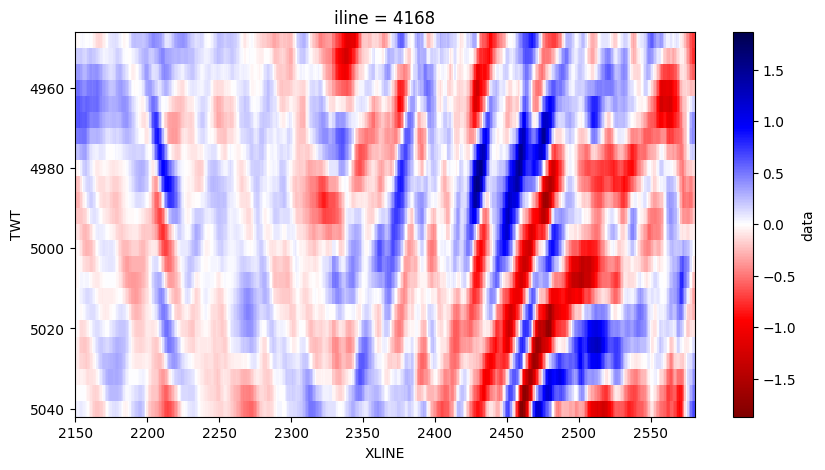

In [95]:
fig, ax1 = plt.subplots(ncols=1, figsize=(10, 5))
iline_sel = 4168
V3D.data.transpose("twt", "iline", "xline", transpose_coords=True).sel(
    iline=iline_sel
).plot(yincrease=False, cmap="seismic_r")
# plt.grid("grey")
plt.ylabel("TWT")
# plt.ylabel("DEPTH");
plt.xlabel("XLINE");
# plt.savefig('seismic_depth_4480.png')

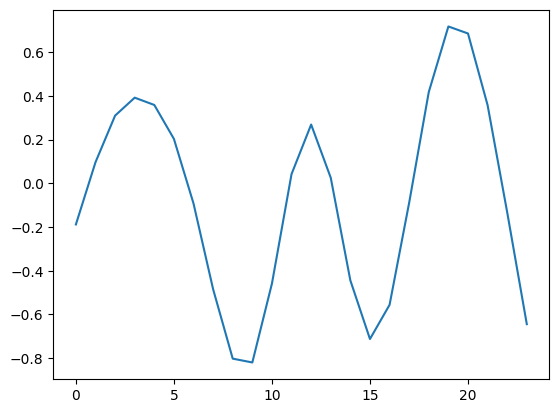

In [96]:
plt.plot(V3D.data.sel(iline=iline_sel,xline=2525).data);

In [97]:
coord3 = [4131, 2572]
coord5 = [4075, 2472]
coord8 = [4102, 2360]
coord9 = [4070, 2155]
coord12 = [4168, 2525]
coord14 = [4065, 2492]
coord18 = [4114, 2500]

In [98]:
sismica3 = V3D.data.sel(iline = 4131, xline = 2572).data
sismica5 = V3D.data.sel(iline = 4075, xline = 2472).data
sismica8 = V3D.data.sel(iline = 4102, xline = 2360).data
sismica9 = V3D.data.sel(iline = 4070, xline = 2155).data
sismica12 = V3D.data.sel(iline = 4168, xline = 2525).data
sismica14 = V3D.data.sel(iline = 4065, xline = 2492).data
sismica18 = V3D.data.sel(iline = 4114, xline = 2500).data

In [99]:
seis3 = pd.read_csv('/home/josegfer/datasets/ffb/drive_fernanda/PINN/Traços/7-BUZ-23-RJS_teste2_26-05.txt')
seis5 = pd.read_csv('/home/josegfer/datasets/ffb/drive_fernanda/PINN/Traços/7-BUZ-29D-RJS_teste2_26-05.txt')
seis8 = pd.read_csv('/home/josegfer/datasets/ffb/drive_fernanda/PINN/Traços/8-BUZ-26-RJS_teste2_26-05.txt')
seis9 = pd.read_csv('/home/josegfer/datasets/ffb/drive_fernanda/PINN/Traços/8-BUZ-28-DA-RJS_teste2_26-05.txt')
seis12 = pd.read_csv('/home/josegfer/datasets/ffb/drive_fernanda/PINN/Traços/8-BUZ-20-RJS_teste2_26-05.txt')
seis14 = pd.read_csv('/home/josegfer/datasets/ffb/drive_fernanda/PINN/Traços/7-BUZ-10-RJS_teste2_26-05.txt')
seis18 = pd.read_csv('/home/josegfer/datasets/ffb/drive_fernanda/PINN/Traços/3-BRSA-1053-RJS_teste2_26-05.txt')

# wavelet

(69,)

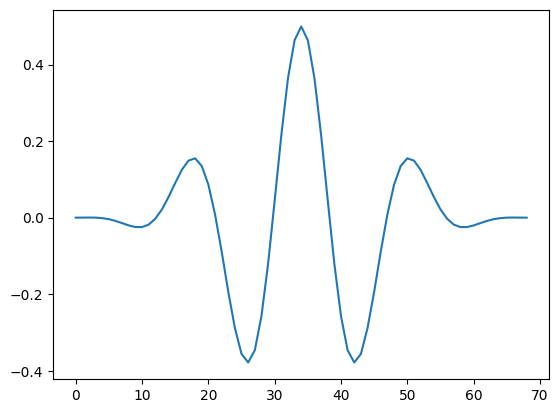

In [27]:
df_15_2_30 = pd.read_csv('/home/josegfer/datasets/ffb/wavelets/wavelet_15_2_30.dat', 
                           header = None, sep = '\t')
wvlt_15_2_30 = df_15_2_30[1].values
plt.plot(wvlt_15_2_30);
wvlt_15_2_30.shape

In [100]:
df_15_2_30

,0,1
0,-68,0.000000
1,-66,0.000143
2,-64,0.000302
3,-62,0.000088
4,-60,-0.001291
...,...,...
64,60,-0.001291
65,62,0.000088
66,64,0.000302
67,66,0.000143


(24,)

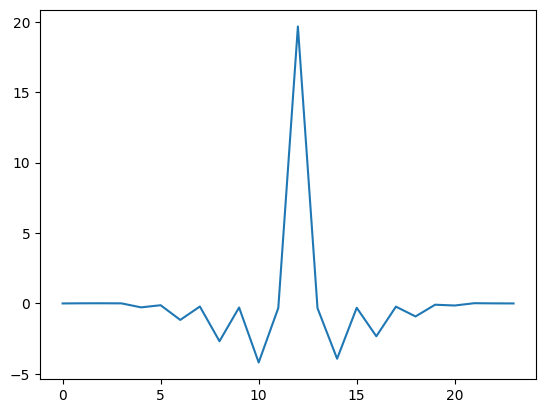

In [28]:
df_90_20_probe = pd.read_csv('/home/josegfer/datasets/ffb/wavelets/WAV_90_20_probe.dat', 
                           header = None, sep = '\t')
wvlt_90_20_probe = df_90_20_probe[1].values
plt.plot(wvlt_90_20_probe);
wvlt_90_20_probe.shape

(24,)

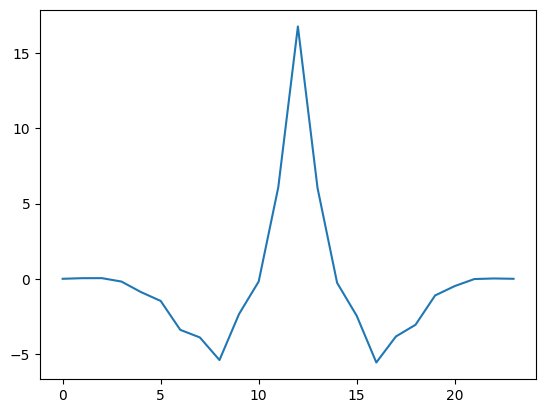

In [29]:
df_sul_90 = pd.read_csv('/home/josegfer/datasets/ffb/wavelets/wavelet_area_menor_sul_90.dat', 
                           header = None, sep = '\t')
wvlt_sul_90 = df_sul_90[1].values
plt.plot(wvlt_sul_90);
wvlt_sul_90.shape

In [73]:
df_sul_90

,0,1
0,-48,5.865000e-16
1,-44,4.037000e-02
2,-40,4.323290e-02
3,-36,-1.839517e-01
4,-32,-8.862650e-01
5,-28,-1.471321e+00
6,-24,-3.393519e+00
7,-20,-3.899724e+00
8,-16,-5.400948e+00
9,-12,-2.337778e+00


(35,)

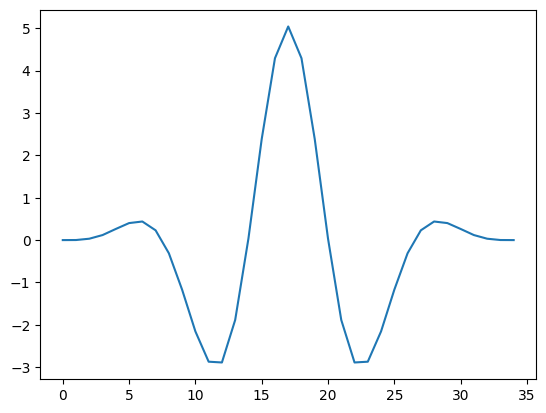

In [30]:
df_sinc_30_2_30 = pd.read_csv('/home/josegfer/datasets/ffb/wavelets/wavelet_sinc_30_2_30.dat', 
                           header = None, sep = '\t')
wvlt_sinc_30_2_30 = df_sinc_30_2_30[1].values
plt.plot(wvlt_sinc_30_2_30);
wvlt_sinc_30_2_30.shape

(51,)

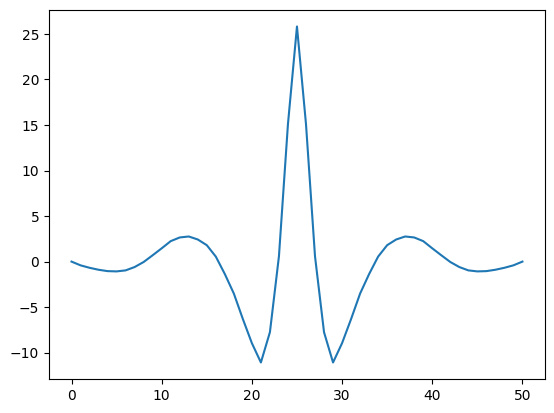

In [31]:
df_200_50 = pd.read_csv('/home/josegfer/datasets/ffb/wavelets/wavelet_200_50.dat', 
                           header = None, sep = '\t')
wvlt_200_50 = df_200_50[1].values
plt.plot(wvlt_200_50);
wvlt_200_50.shape

(51,)

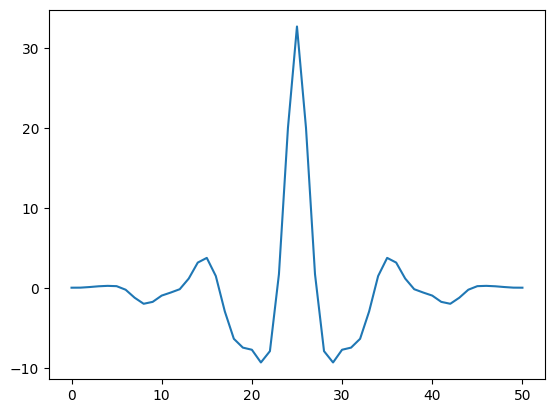

In [32]:
df_200_50_probe = pd.read_csv('/home/josegfer/datasets/ffb/wavelets/wavelet_200_50_probe.dat', 
                           header = None, sep = '\t')
wvlt_200_50_probe = df_200_50_probe[1].values
plt.plot(wvlt_200_50_probe);
wvlt_200_50_probe.shape

(35,)

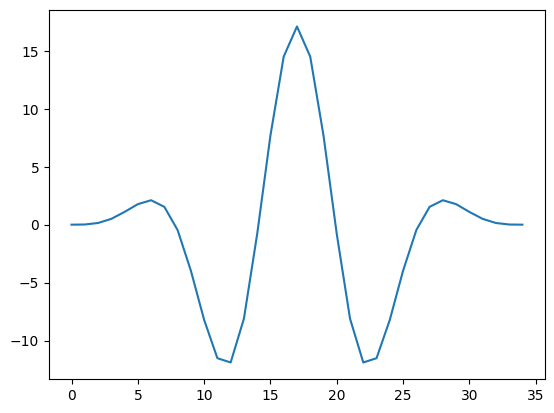

In [33]:
df_30_2_30 = pd.read_csv('/home/josegfer/datasets/ffb/wavelets/wav_30_2_30.dat', 
                           header = None, sep = '\t')
wvlt_30_2_30 = df_30_2_30[1].values
plt.plot(wvlt_30_2_30);
wvlt_30_2_30.shape

(35,)

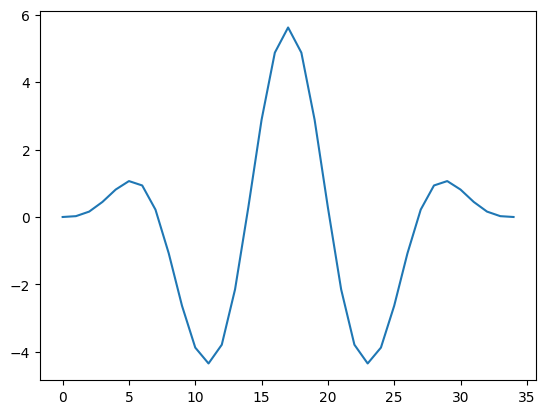

In [34]:
df_s_30_2_30 = pd.read_csv('/home/josegfer/datasets/ffb/wavelets/wav_s_30_2_30.dat', 
                           header = None, sep = '\t')
wvlt_s_30_2_30 = df_s_30_2_30[1].values
plt.plot(wvlt_s_30_2_30);
wvlt_s_30_2_30.shape

(41,)

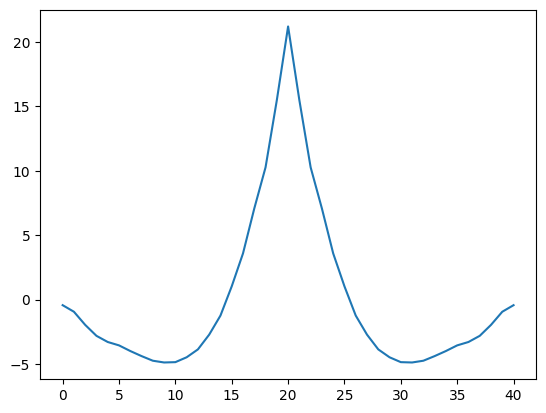

In [35]:
df_8_buz_20 = pd.read_csv('/home/josegfer/datasets/ffb/wavelets/wavelet_8_buz_20.dat', 
                           header = None, sep = '\t')
wvlt_8_buz_20 = df_8_buz_20[1].values
plt.plot(wvlt_8_buz_20);
wvlt_8_buz_20.shape

(25,)

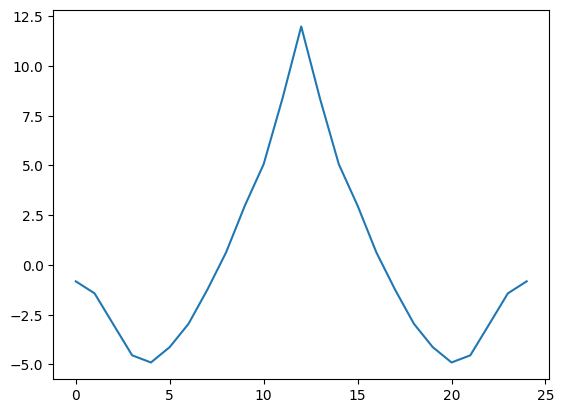

In [36]:
df_8_buz_20_25 = pd.read_csv('/home/josegfer/datasets/ffb/wavelets/wav_8-buz-20.dat', 
                           header = None, sep = '\t')
wvlt_8_buz_20_25 = df_8_buz_20_25[1].values
plt.plot(wvlt_8_buz_20_25);
wvlt_8_buz_20_25.shape

# inversao

In [37]:
depth_point1 = 4948
depth_point2 = 5040

## well 3

In [38]:
idx3 = (twt3 > depth_point1) * (twt3 < depth_point2)
imp3 = vp3 * rho3

# philow3 = escala_sismica(twt3[idx3], phi3[idx3], np.array(V3D.data), depth_point1, depth_point2)
# implow3 = escala_sismica(twt3[idx3], imp3[idx3], np.array(V3D.data), depth_point1, depth_point2)
imp3 = imp3[idx3]

Rpp3 = RC_fwd_model_ia(imp3[:-1], imp3[1:])
Rpplast3 = 0.0 / imp3[0]
Rpp3 = np.concatenate([Rpp3, np.expand_dims(Rpplast3, axis = 0)], axis = 0)

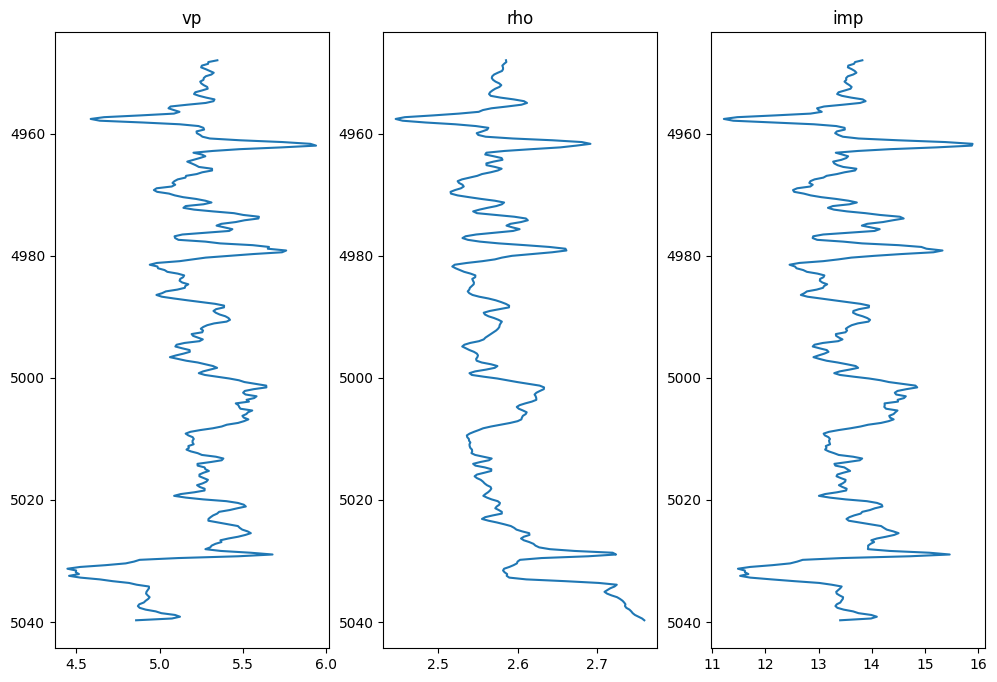

In [39]:
fig, axes = plt.subplots(1, 3, figsize = (12, 8))
zz = np.linspace(depth_point1, depth_point2, len(imp3) + 1)

axes[0].plot(vp3[idx3], zz[:-1]);
axes[0].invert_yaxis();
axes[0].set_title('vp');

axes[1].plot(rho3[idx3], zz[:-1]);
axes[1].invert_yaxis();
axes[1].set_title('rho');

axes[2].plot(imp3, zz[:-1]);
axes[2].invert_yaxis();
axes[2].set_title('imp');

In [69]:
dpt3[idx3]

array([5802.3252, 5802.4776, 5802.63  , 5802.7824, 5802.9348, 5803.0872,
       5803.2396, 5803.392 , 5803.5444, 5803.6968, 5803.8492, 5804.0016,
       5804.154 , 5804.3064, 5804.4588, 5804.6112, 5804.7636, 5804.916 ,
       5805.0684, 5805.2208, 5805.3732, 5805.5256, 5805.678 , 5805.8304,
       5805.9828, 5806.1352, 5806.2876, 5806.44  , 5806.5924, 5806.7448,
       5806.8972, 5807.0496, 5807.202 , 5807.3544, 5807.5068, 5807.6592,
       5807.8116, 5807.964 , 5808.1164, 5808.2688, 5808.4212, 5808.5736,
       5808.726 , 5808.8784, 5809.0308, 5809.1832, 5809.3356, 5809.488 ,
       5809.6404, 5809.7928, 5809.9452, 5810.0976, 5810.25  , 5810.4024,
       5810.5548, 5810.7072, 5810.8596, 5811.012 , 5811.1644, 5811.3168,
       5811.4692, 5811.6216, 5811.774 , 5811.9264, 5812.0788, 5812.2312,
       5812.3836, 5812.536 , 5812.6884, 5812.8408, 5812.9932, 5813.1456,
       5813.298 , 5813.4504, 5813.6028, 5813.7552, 5813.9076, 5814.06  ,
       5814.2124, 5814.3648, 5814.5172, 5814.6696, 

In [102]:
seis3

,TVDSS (m),Value
0,-25.0,NaN
1,-20.0,NaN
2,-15.0,NaN
3,-10.0,NaN
4,-5.0,NaN
...,...,...
1196,5955.0,0.318564
1197,5960.0,0.421449
1198,5965.0,0.549517
1199,5970.0,0.664999


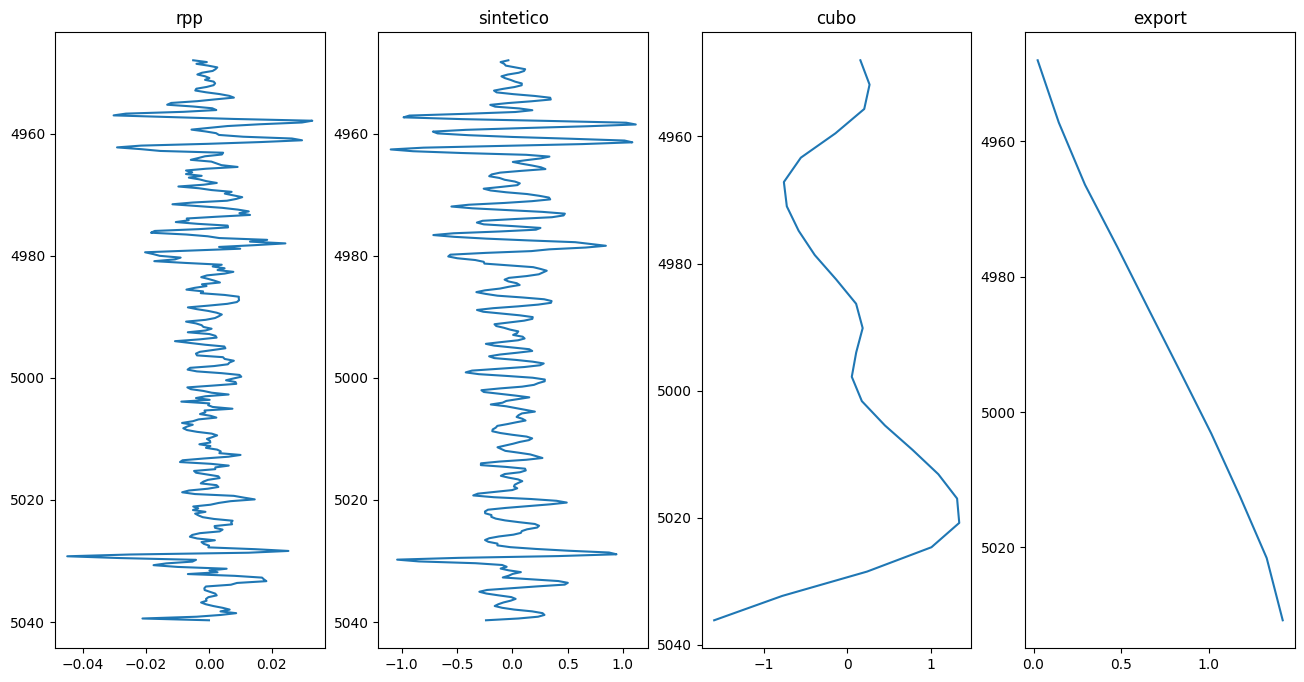

In [68]:
# synth3 = np.convolve(wvlt_15_2_30, Rpp3[:-1], mode = 'same') # wavelet_15_2_30
# synth3 = np.convolve(wvlt_90_20_probe, Rpp3[:-1], mode = 'same') # WAV_90_20_probe
synth3 = np.convolve(wvlt_sul_90, Rpp3[:-1], mode = 'same') # wavelet_area_menor_sul_90
# synth3 = np.convolve(wvlt_sinc_30_2_30, Rpp3[:-1], mode = 'same') # wavelet_sinc_30_2_30
# synth3 = np.convolve(wvlt_200_50, Rpp3[:-1], mode = 'same') # wavelet_200_50
# synth3 = np.convolve(wvlt_200_50_probe, Rpp3[:-1], mode = 'same') # wavelet_200_50_probe
# synth3 = np.convolve(wvlt_30_2_30, Rpp3[:-1], mode = 'same') # wav_30_2_30
# synth3 = np.convolve(wvlt_s_30_2_30, Rpp3[:-1], mode = 'same') # wav_s_30_2_30
# synth3 = np.convolve(wvlt_8_buz_20, Rpp3[:-1], mode = 'same') # wavelet_8_buz_20
# synth3 = np.convolve(wvlt_8_buz_20_25, Rpp3[:-1], mode = 'same') # wav_8-buz-20

dpt_point1 = dpt3[idx3][0]
dpt_point2 = dpt3[idx3][-1]
csv3 = (seis3['TVDSS (m)'] > dpt_point1) * (seis3['TVDSS (m)'] < dpt_point2)

fig, axes = plt.subplots(1, 4, figsize = (16, 8))

zz = np.linspace(depth_point1, depth_point2, len(Rpp3) + 1)
axes[0].plot(Rpp3, zz[:-1]);
axes[0].invert_yaxis();
axes[0].set_title('rpp');

zz = np.linspace(depth_point1, depth_point2, synth3.shape[0] + 1)
axes[1].plot(synth3, zz[:-1]);
axes[1].invert_yaxis();
axes[1].set_title('sintetico');

zz = np.linspace(depth_point1, depth_point2, len(sismica3) + 1)
axes[2].plot(sismica3, zz[:-1]);
axes[2].invert_yaxis();
axes[2].set_title('cubo');

zz = np.linspace(depth_point1, depth_point2, sum(csv3) + 1)
axes[3].plot(seis3['Value'].loc[csv3].values, zz[:-1]);
axes[3].invert_yaxis();
axes[3].set_title('export');

## well 5

In [41]:
idx5 = (twt5 > depth_point1) * (twt5 < depth_point2)
imp5 = vp5 * rho5
imp5 = imp5[idx5]
Rpp5 = RC_fwd_model_ia(imp5[:-1], imp5[1:])
Rpplast5 = 0.0 / imp5[0]
Rpp5 = np.concatenate([Rpp5, np.expand_dims(Rpplast5, axis = 0)], axis = 0)

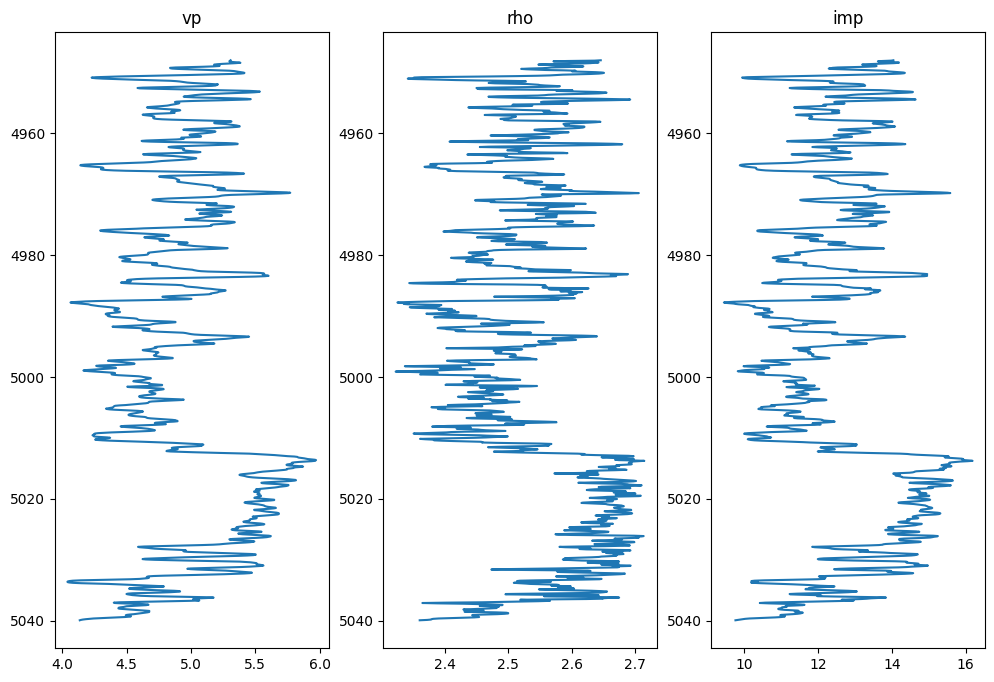

In [42]:
fig, axes = plt.subplots(1, 3, figsize = (12, 8))
zz = np.linspace(depth_point1, depth_point2, len(imp5) + 1)
axes[0].plot(vp5[idx5], zz[:-1]);
axes[0].invert_yaxis();
axes[0].set_title('vp');
axes[1].plot(rho5[idx5], zz[:-1]);
axes[1].invert_yaxis();
axes[1].set_title('rho');
axes[2].plot(imp5, zz[:-1]);
axes[2].invert_yaxis();
axes[2].set_title('imp');

In [110]:
dpt5[idx5]

array([5467.521 , 5467.6734, 5467.8258, ..., 5704.3311, 5704.4834,
       5704.6358])

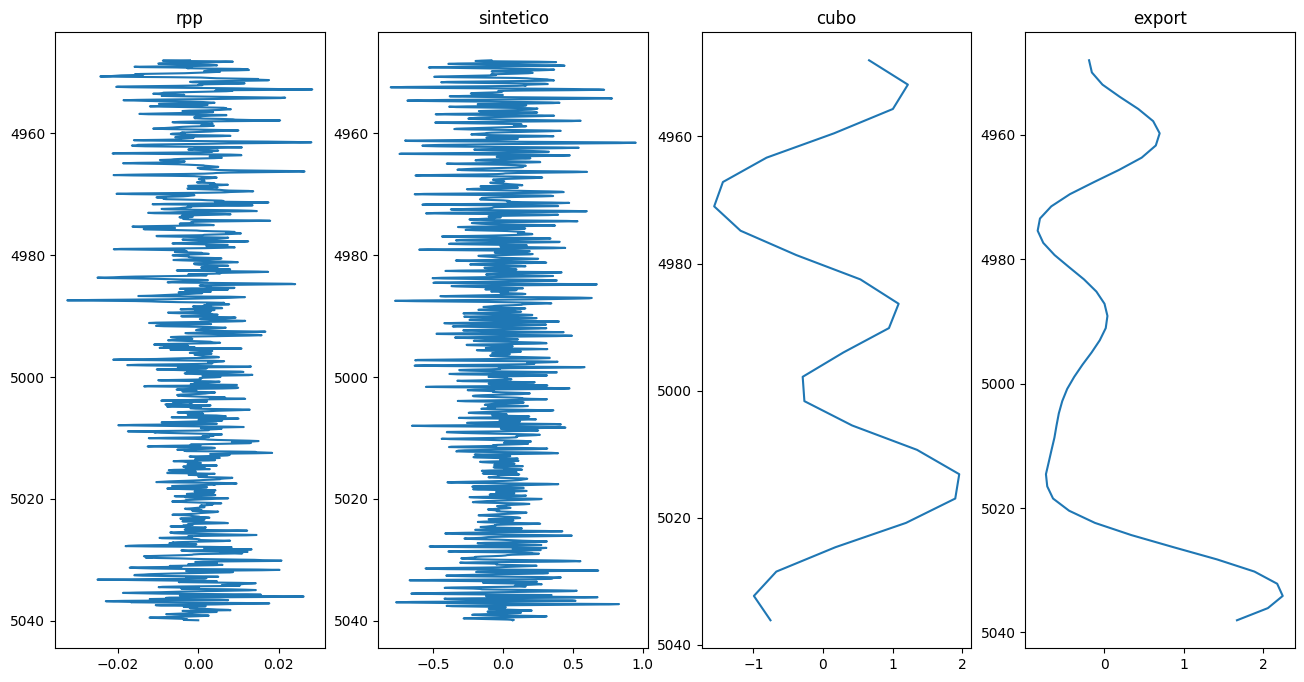

In [111]:
# synth5 = np.convolve(wvlt_15_2_30, Rpp5[:-1], mode = 'same') # wavelet_15_2_30
# synth5 = np.convolve(wvlt_90_20_probe, Rpp5[:-1], mode = 'same') # WAV_90_20_probe
synth5 = np.convolve(wvlt_sul_90, Rpp5[:-1], mode = 'same') # wavelet_area_menor_sul_90
# synth5 = np.convolve(wvlt_sinc_30_2_30, Rpp5[:-1], mode = 'same') # wavelet_sinc_30_2_30
# synth5 = np.convolve(wvlt_200_50, Rpp5[:-1], mode = 'same') # wavelet_200_50
# synth5 = np.convolve(wvlt_200_50_probe, Rpp5[:-1], mode = 'same') # wavelet_200_50_probe
# synth5 = np.convolve(wvlt_30_2_30, Rpp5[:-1], mode = 'same') # wav_30_2_30
# synth5 = np.convolve(wvlt_s_30_2_30, Rpp5[:-1], mode = 'same') # wav_s_30_2_30
# synth5 = np.convolve(wvlt_8_buz_20, Rpp5[:-1], mode = 'same') # wavelet_8_buz_20
# synth5 = np.convolve(wvlt_8_buz_20_25, Rpp5[:-1], mode = 'same') # wav_8-buz-20

dpt_point1 = dpt5[idx5][0]
dpt_point2 = dpt5[idx5][-1]

csv5 = (seis5['TVDSS (m)'] > dpt_point1) * (seis5['TVDSS (m)'] < dpt_point2)
fig, axes = plt.subplots(1, 4, figsize = (16, 8))
zz = np.linspace(depth_point1, depth_point2, len(Rpp5) + 1)
axes[0].plot(Rpp5, zz[:-1]);
axes[0].invert_yaxis();
axes[0].set_title('rpp');
zz = np.linspace(depth_point1, depth_point2, synth5.shape[0] + 1)
axes[1].plot(synth5, zz[:-1]);
axes[1].invert_yaxis();
axes[1].set_title('sintetico');
zz = np.linspace(depth_point1, depth_point2, len(sismica5) + 1)
axes[2].plot(sismica5, zz[:-1]);
axes[2].invert_yaxis();
axes[2].set_title('cubo');
zz = np.linspace(depth_point1, depth_point2, sum(csv5) + 1)
axes[3].plot(seis5['Value'].loc[csv5].values, zz[:-1]);
axes[3].invert_yaxis();
axes[3].set_title('poço');

tratar os dados \
(i) cubo sismico com pad \
(ii) unidade da wavelet \
(iii) qual o traço sismico _certo_ de cada poço (profundidade -> tempo) \
---
(iv) como avaliar qualitativamente o rpp e o sintetico (passa baixa) \
---
(v) qual amostragem gerar o phi

In [44]:
np.sum(idx3), np.sum(idx5)

(316, 1557)

## well 8

In [45]:
idx8 = (twt8 > depth_point1) * (twt8 < depth_point2)
imp8 = vp8 * rho8
imp8 = imp8[idx8]
Rpp8 = RC_fwd_model_ia(imp8[:-1], imp8[1:])
Rpplast8 = 0.0 / imp8[0]
Rpp8 = np.concatenate([Rpp8, np.expand_dims(Rpplast8, axis = 0)], axis = 0)

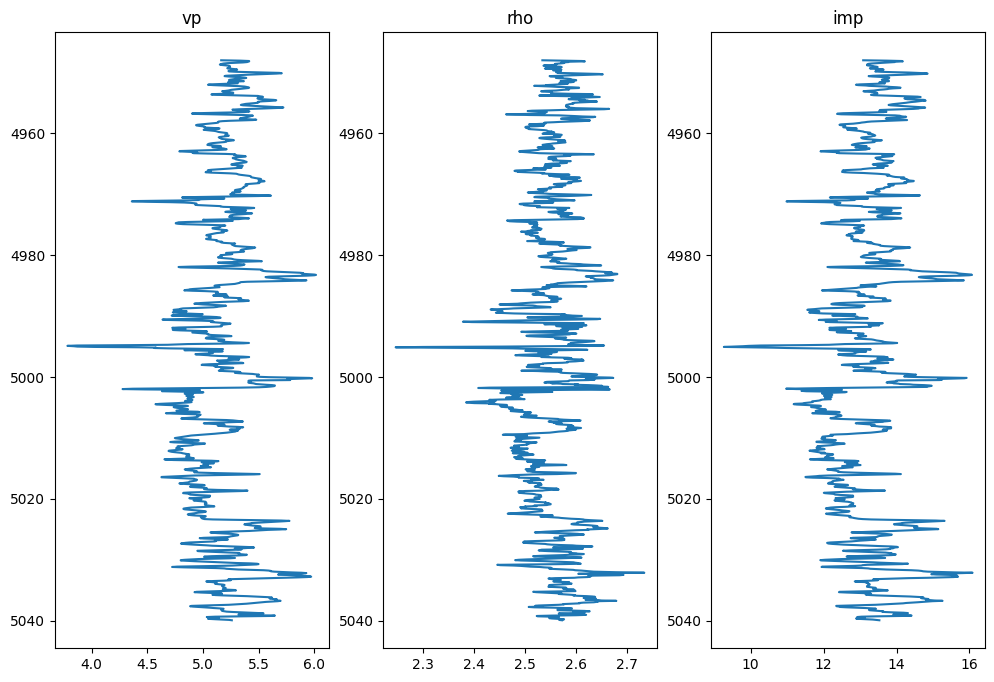

In [46]:
fig, axes = plt.subplots(1, 3, figsize = (12, 8))
zz = np.linspace(depth_point1, depth_point2, len(imp8) + 1)
axes[0].plot(vp8[idx8], zz[:-1]);
axes[0].invert_yaxis();
axes[0].set_title('vp');
axes[1].plot(rho8[idx8], zz[:-1]);
axes[1].invert_yaxis();
axes[1].set_title('rho');
axes[2].plot(imp8, zz[:-1]);
axes[2].invert_yaxis();
axes[2].set_title('imp');

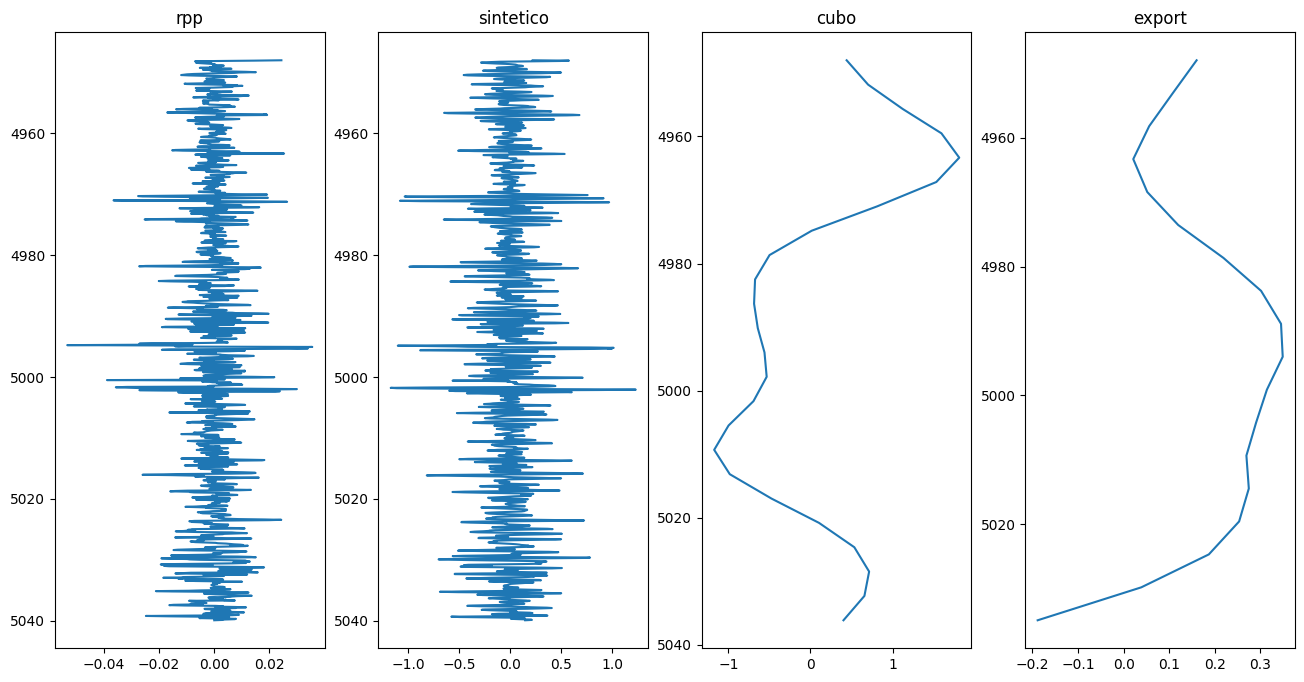

In [47]:
# synth8 = np.convolve(wvlt_15_2_30, Rpp8[:-1], mode = 'same') # wavelet_15_2_30
# synth8 = np.convolve(wvlt_90_20_probe, Rpp8[:-1], mode = 'same') # WAV_90_20_probe
synth8 = np.convolve(wvlt_sul_90, Rpp8[:-1], mode = 'same') # wavelet_area_menor_sul_90
# synth8 = np.convolve(wvlt_sinc_30_2_30, Rpp8[:-1], mode = 'same') # wavelet_sinc_30_2_30
# synth8 = np.convolve(wvlt_200_50, Rpp8[:-1], mode = 'same') # wavelet_200_50
# synth8 = np.convolve(wvlt_200_50_probe, Rpp8[:-1], mode = 'same') # wavelet_200_50_probe
# synth8 = np.convolve(wvlt_30_2_30, Rpp8[:-1], mode = 'same') # wav_30_2_30
# synth8 = np.convolve(wvlt_s_30_2_30, Rpp8[:-1], mode = 'same') # wav_s_30_2_30
# synth8 = np.convolve(wvlt_8_buz_20, Rpp8[:-1], mode = 'same') # wavelet_8_buz_20
# synth8 = np.convolve(wvlt_8_buz_20_25, Rpp8[:-1], mode = 'same') # wav_8-buz-20
csv8 = (seis8['TVDSS (m)'] > depth_point1) * (seis8['TVDSS (m)'] < depth_point2)
fig, axes = plt.subplots(1, 4, figsize = (16, 8))
zz = np.linspace(depth_point1, depth_point2, len(Rpp8) + 1)
axes[0].plot(Rpp8, zz[:-1]);
axes[0].invert_yaxis();
axes[0].set_title('rpp');
zz = np.linspace(depth_point1, depth_point2, synth8.shape[0] + 1)
axes[1].plot(synth8, zz[:-1]);
axes[1].invert_yaxis();
axes[1].set_title('sintetico');
zz = np.linspace(depth_point1, depth_point2, len(sismica8) + 1)
axes[2].plot(sismica8, zz[:-1]);
axes[2].invert_yaxis();
axes[2].set_title('cubo');
zz = np.linspace(depth_point1, depth_point2, sum(csv8) + 1)
axes[3].plot(seis8['Value'].loc[csv8].values, zz[:-1]);
axes[3].invert_yaxis();
axes[3].set_title('export');

In [48]:
np.sum(idx3), np.sum(idx8)

(316, 1556)

## well 9

In [49]:
idx9 = (twt9 > depth_point1) * (twt9 < depth_point2)
imp9 = vp9 * rho9
imp9 = imp9[idx9]
Rpp9 = RC_fwd_model_ia(imp9[:-1], imp9[1:])
Rpplast9 = 0.0 / imp9[0]
Rpp9 = np.concatenate([Rpp9, np.expand_dims(Rpplast9, axis = 0)], axis = 0)

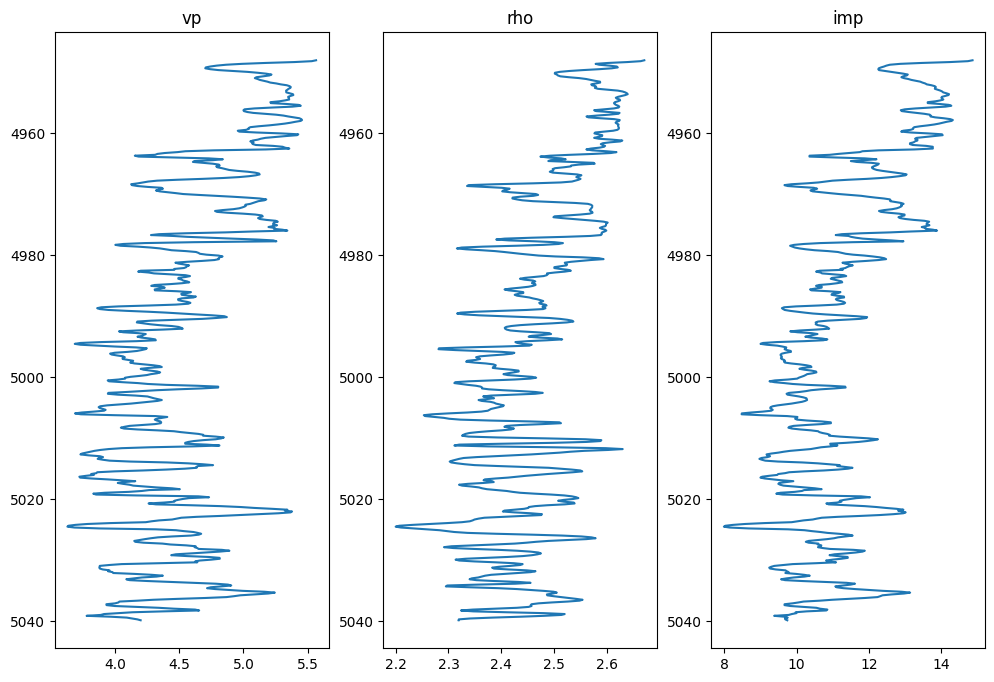

In [50]:
fig, axes = plt.subplots(1, 3, figsize = (12, 8))
zz = np.linspace(depth_point1, depth_point2, len(imp9) + 1)
axes[0].plot(vp9[idx9], zz[:-1]);
axes[0].invert_yaxis();
axes[0].set_title('vp');
axes[1].plot(rho9[idx9], zz[:-1]);
axes[1].invert_yaxis();
axes[1].set_title('rho');
axes[2].plot(imp9, zz[:-1]);
axes[2].invert_yaxis();
axes[2].set_title('imp');

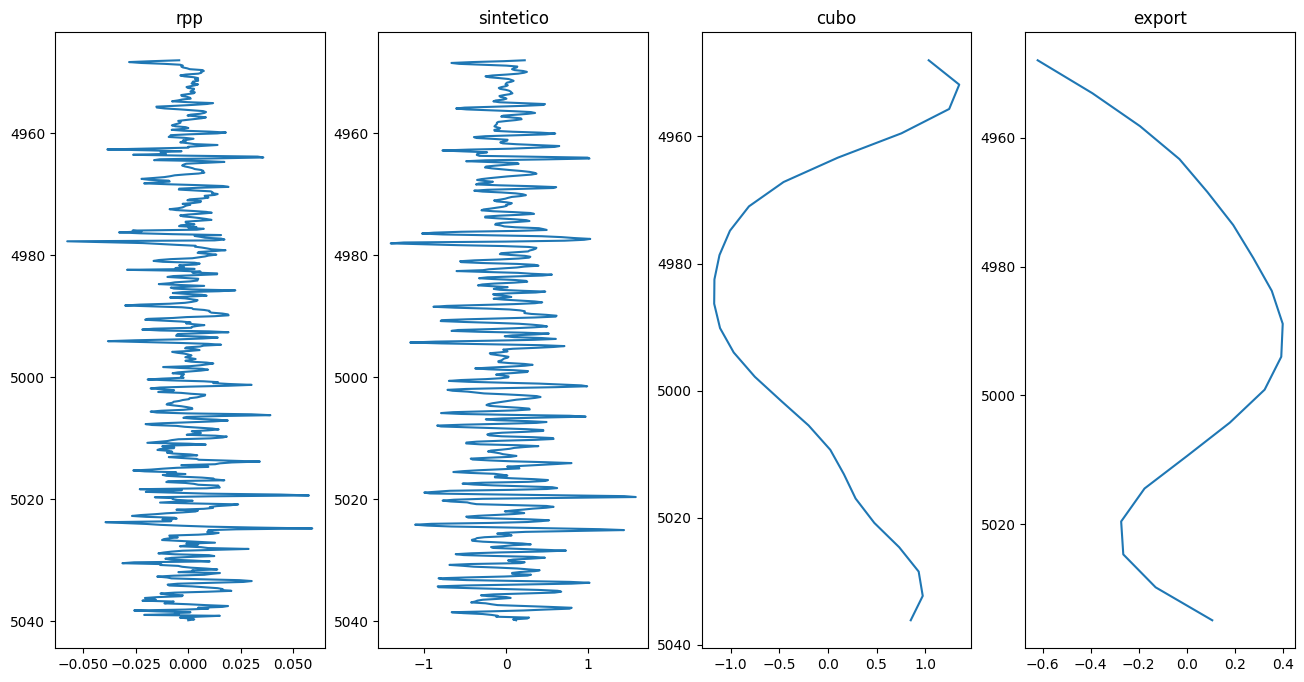

In [51]:
# synth9 = np.convolve(wvlt_15_2_30, Rpp9[:-1], mode = 'same') # wavelet_15_2_30
# synth9 = np.convolve(wvlt_90_20_probe, Rpp9[:-1], mode = 'same') # WAV_90_20_probe
synth9 = np.convolve(wvlt_sul_90, Rpp9[:-1], mode = 'same') # wavelet_area_menor_sul_90
# synth9 = np.convolve(wvlt_sinc_30_2_30, Rpp9[:-1], mode = 'same') # wavelet_sinc_30_2_30
# synth9 = np.convolve(wvlt_200_50, Rpp9[:-1], mode = 'same') # wavelet_200_50
# synth9 = np.convolve(wvlt_200_50_probe, Rpp9[:-1], mode = 'same') # wavelet_200_50_probe
# synth9 = np.convolve(wvlt_30_2_30, Rpp9[:-1], mode = 'same') # wav_30_2_30
# synth9 = np.convolve(wvlt_s_30_2_30, Rpp9[:-1], mode = 'same') # wav_s_30_2_30
# synth9 = np.convolve(wvlt_8_buz_20, Rpp9[:-1], mode = 'same') # wavelet_8_buz_20
# synth9 = np.convolve(wvlt_8_buz_20_25, Rpp9[:-1], mode = 'same') # wav_8-buz-20
csv9 = (seis9['TVDSS (m)'] > depth_point1) * (seis9['TVDSS (m)'] < depth_point2)
fig, axes = plt.subplots(1, 4, figsize = (16, 8))
zz = np.linspace(depth_point1, depth_point2, len(Rpp9) + 1)
axes[0].plot(Rpp9, zz[:-1]);
axes[0].invert_yaxis();
axes[0].set_title('rpp');
zz = np.linspace(depth_point1, depth_point2, synth9.shape[0] + 1)
axes[1].plot(synth9, zz[:-1]);
axes[1].invert_yaxis();
axes[1].set_title('sintetico');
zz = np.linspace(depth_point1, depth_point2, len(sismica9) + 1)
axes[2].plot(sismica9, zz[:-1]);
axes[2].invert_yaxis();
axes[2].set_title('cubo');
zz = np.linspace(depth_point1, depth_point2, sum(csv9) + 1)
axes[3].plot(seis9['Value'].loc[csv9].values, zz[:-1]);
axes[3].invert_yaxis();
axes[3].set_title('export');

## well 12

In [52]:
idx12 = (twt12 > depth_point1) * (twt12 < depth_point2)
imp12 = vp12 * rho12
imp12 = imp12[idx12]
Rpp12 = RC_fwd_model_ia(imp12[:-1], imp12[1:])
Rpplast12 = 0.0 / imp12[0]
Rpp12 = np.concatenate([Rpp12, np.expand_dims(Rpplast12, axis = 0)], axis = 0)

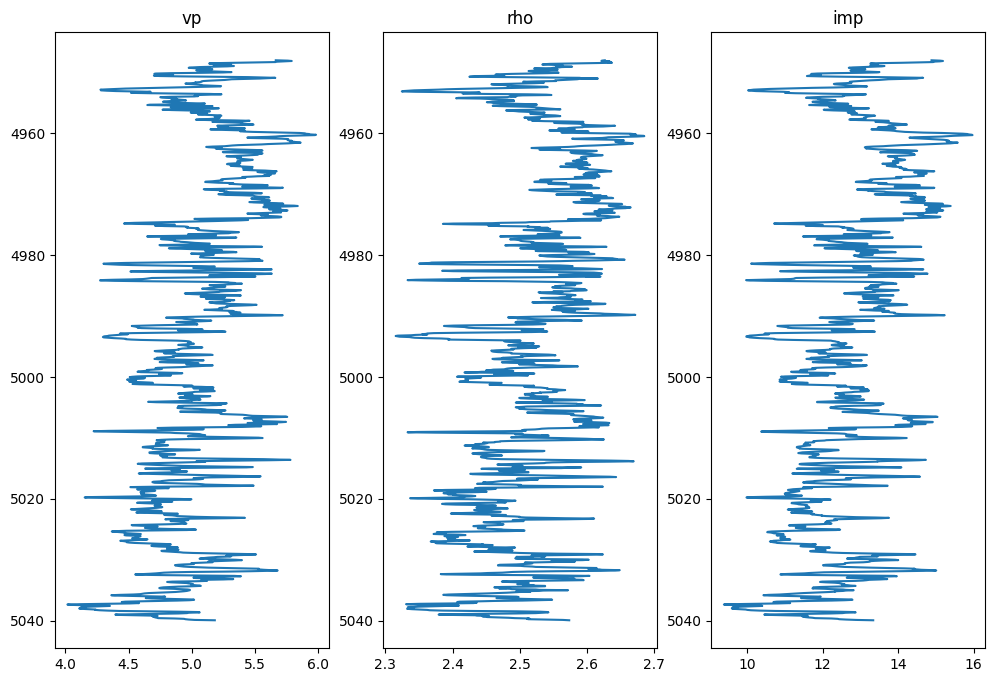

In [53]:
fig, axes = plt.subplots(1, 3, figsize = (12, 8))
zz = np.linspace(depth_point1, depth_point2, len(imp12) + 1)
axes[0].plot(vp12[idx12], zz[:-1]);
axes[0].invert_yaxis();
axes[0].set_title('vp');
axes[1].plot(rho12[idx12], zz[:-1]);
axes[1].invert_yaxis();
axes[1].set_title('rho');
axes[2].plot(imp12, zz[:-1]);
axes[2].invert_yaxis();
axes[2].set_title('imp');

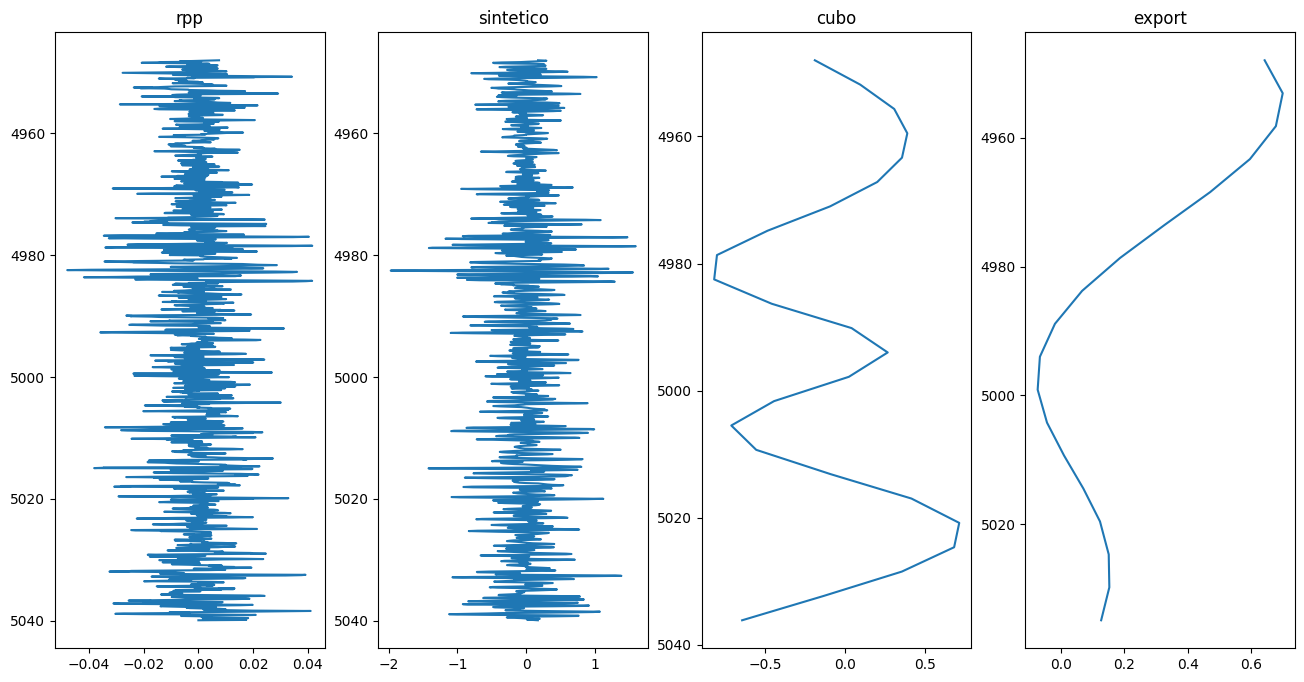

In [54]:
# synth12 = np.convolve(wvlt_15_2_30, Rpp12[:-1], mode = 'same') # wavelet_15_2_30
# synth12 = np.convolve(wvlt_90_20_probe, Rpp12[:-1], mode = 'same') # WAV_90_20_probe
synth12 = np.convolve(wvlt_sul_90, Rpp12[:-1], mode = 'same') # wavelet_area_menor_sul_90
# synth12 = np.convolve(wvlt_sinc_30_2_30, Rpp12[:-1], mode = 'same') # wavelet_sinc_30_2_30
# synth12 = np.convolve(wvlt_200_50, Rpp12[:-1], mode = 'same') # wavelet_200_50
# synth12 = np.convolve(wvlt_200_50_probe, Rpp12[:-1], mode = 'same') # wavelet_200_50_probe
# synth12 = np.convolve(wvlt_30_2_30, Rpp12[:-1], mode = 'same') # wav_30_2_30
# synth12 = np.convolve(wvlt_s_30_2_30, Rpp12[:-1], mode = 'same') # wav_s_30_2_30
# synth12 = np.convolve(wvlt_8_buz_20, Rpp12[:-1], mode = 'same') # wavelet_8_buz_20
# synth12 = np.convolve(wvlt_8_buz_20_25, Rpp12[:-1], mode = 'same') # wav_8-buz-20
csv12 = (seis12['TVDSS (m)'] > depth_point1) * (seis12['TVDSS (m)'] < depth_point2)
fig, axes = plt.subplots(1, 4, figsize = (16, 8))
zz = np.linspace(depth_point1, depth_point2, len(Rpp12) + 1)
axes[0].plot(Rpp12, zz[:-1]);
axes[0].invert_yaxis();
axes[0].set_title('rpp');
zz = np.linspace(depth_point1, depth_point2, synth12.shape[0] + 1)
axes[1].plot(synth12, zz[:-1]);
axes[1].invert_yaxis();
axes[1].set_title('sintetico');
zz = np.linspace(depth_point1, depth_point2, len(sismica12) + 1)
axes[2].plot(sismica12, zz[:-1]);
axes[2].invert_yaxis();
axes[2].set_title('cubo');
zz = np.linspace(depth_point1, depth_point2, sum(csv12) + 1)
axes[3].plot(seis12['Value'].loc[csv12].values, zz[:-1]);
axes[3].invert_yaxis();
axes[3].set_title('export');

## well 14

In [55]:
idx14 = (twt14 > depth_point1) * (twt14 < depth_point2)
imp14 = vp14 * rho14
imp14 = imp14[idx14]
Rpp14 = RC_fwd_model_ia(imp14[:-1], imp14[1:])
Rpplast14 = 0.0 / imp14[0]
Rpp14 = np.concatenate([Rpp14, np.expand_dims(Rpplast14, axis = 0)], axis = 0)

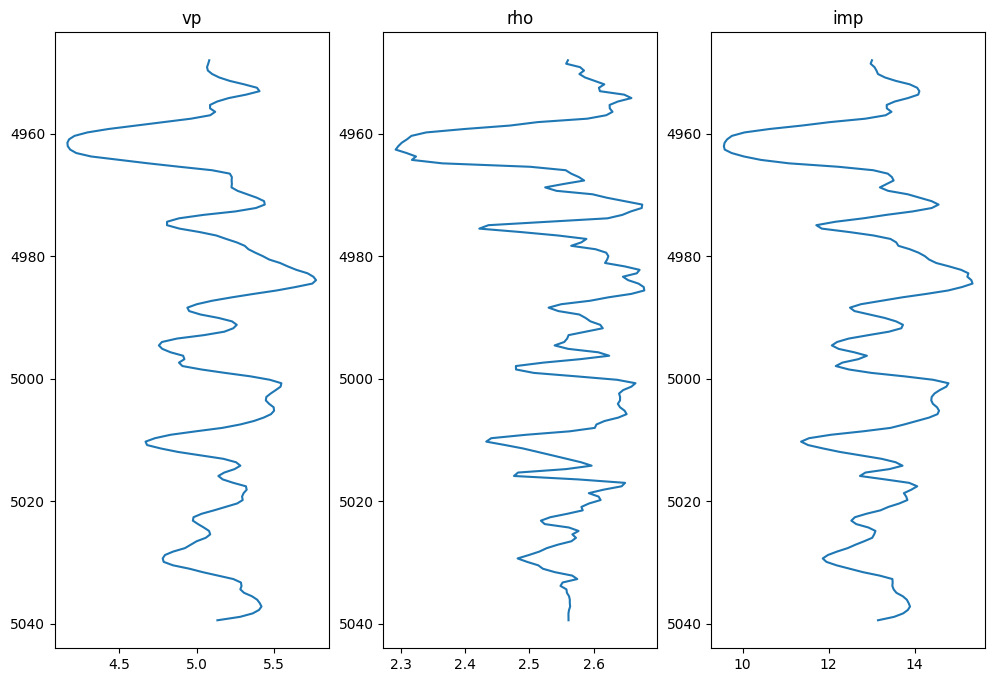

In [56]:
fig, axes = plt.subplots(1, 3, figsize = (12, 8))
zz = np.linspace(depth_point1, depth_point2, len(imp14) + 1)
axes[0].plot(vp14[idx14], zz[:-1]);
axes[0].invert_yaxis();
axes[0].set_title('vp');
axes[1].plot(rho14[idx14], zz[:-1]);
axes[1].invert_yaxis();
axes[1].set_title('rho');
axes[2].plot(imp14, zz[:-1]);
axes[2].invert_yaxis();
axes[2].set_title('imp');

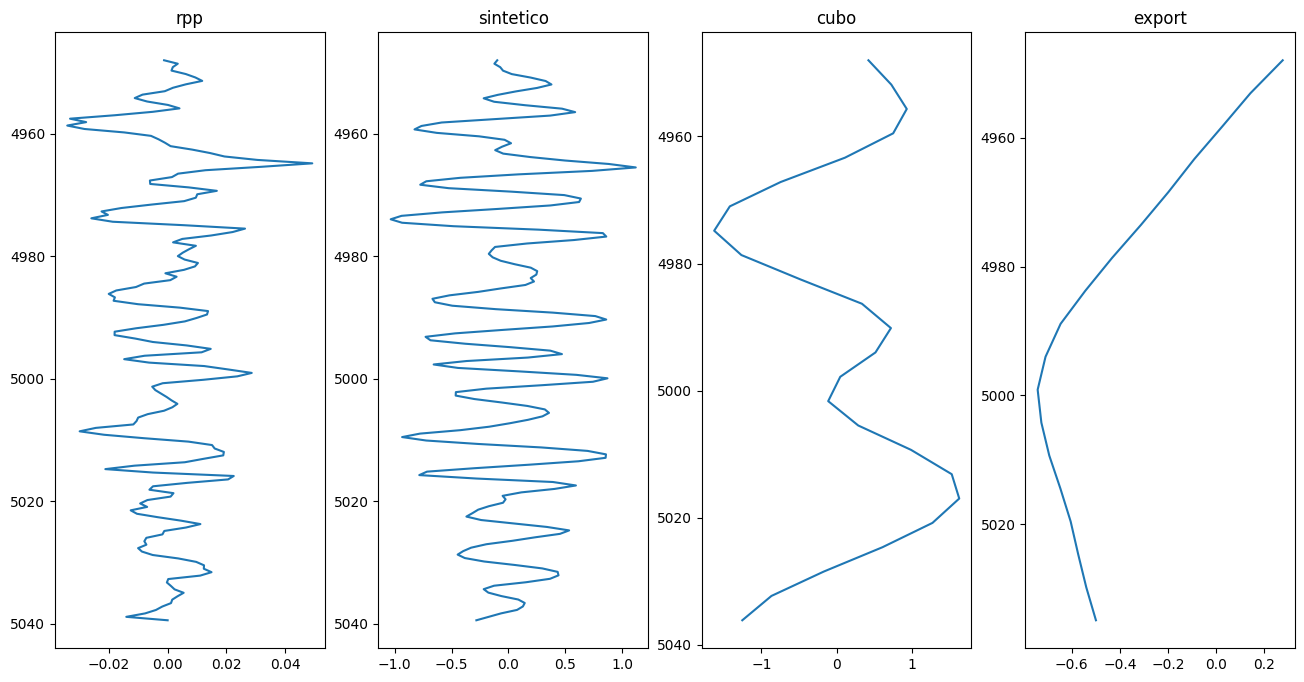

In [57]:
# synth14 = np.convolve(wvlt_15_2_30, Rpp14[:-1], mode = 'same') # wavelet_15_2_30
# synth14 = np.convolve(wvlt_90_20_probe, Rpp14[:-1], mode = 'same') # WAV_90_20_probe
synth14 = np.convolve(wvlt_sul_90, Rpp14[:-1], mode = 'same') # wavelet_area_menor_sul_90
# synth14 = np.convolve(wvlt_sinc_30_2_30, Rpp14[:-1], mode = 'same') # wavelet_sinc_30_2_30
# synth14 = np.convolve(wvlt_200_50, Rpp14[:-1], mode = 'same') # wavelet_200_50
# synth14 = np.convolve(wvlt_200_50_probe, Rpp14[:-1], mode = 'same') # wavelet_200_50_probe
# synth14 = np.convolve(wvlt_30_2_30, Rpp14[:-1], mode = 'same') # wav_30_2_30
# synth14 = np.convolve(wvlt_s_30_2_30, Rpp14[:-1], mode = 'same') # wav_s_30_2_30
# synth14 = np.convolve(wvlt_8_buz_20, Rpp14[:-1], mode = 'same') # wavelet_8_buz_20
# synth14 = np.convolve(wvlt_8_buz_20_25, Rpp14[:-1], mode = 'same') # wav_8-buz-20
csv14 = (seis14['TVDSS (m)'] > depth_point1) * (seis14['TVDSS (m)'] < depth_point2)
fig, axes = plt.subplots(1, 4, figsize = (16, 8))
zz = np.linspace(depth_point1, depth_point2, len(Rpp14) + 1)
axes[0].plot(Rpp14, zz[:-1]);
axes[0].invert_yaxis();
axes[0].set_title('rpp');
zz = np.linspace(depth_point1, depth_point2, synth14.shape[0] + 1)
axes[1].plot(synth14, zz[:-1]);
axes[1].invert_yaxis();
axes[1].set_title('sintetico');
zz = np.linspace(depth_point1, depth_point2, len(sismica14) + 1)
axes[2].plot(sismica14, zz[:-1]);
axes[2].invert_yaxis();
axes[2].set_title('cubo');
zz = np.linspace(depth_point1, depth_point2, sum(csv14) + 1)
axes[3].plot(seis14['Value'].loc[csv14].values, zz[:-1]);
axes[3].invert_yaxis();
axes[3].set_title('export');

In [58]:
np.sum(idx3), np.sum(idx14)

(316, 164)

## well 18

In [59]:
idx18 = (twt18 > depth_point1) * (twt18 < depth_point2)
imp18 = vp18 * rho18
imp18 = imp18[idx18]
Rpp18 = RC_fwd_model_ia(imp18[:-1], imp18[1:])
Rpplast18 = 0.0 / imp18[0]
Rpp18 = np.concatenate([Rpp18, np.expand_dims(Rpplast18, axis = 0)], axis = 0)

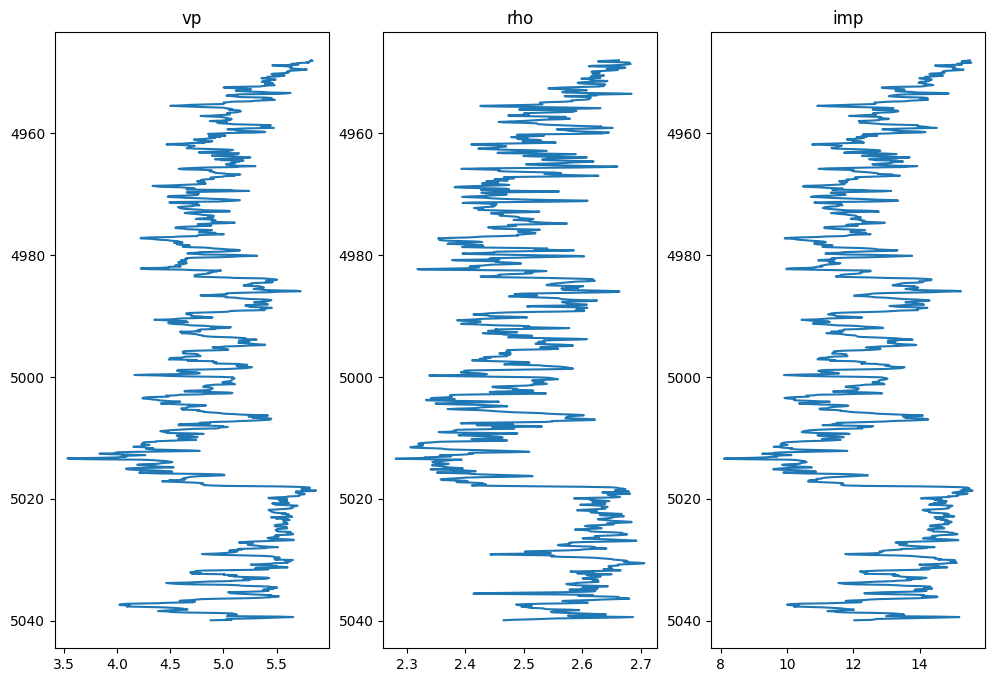

In [60]:
fig, axes = plt.subplots(1, 3, figsize = (12, 8))
zz = np.linspace(depth_point1, depth_point2, len(imp18) + 1)
axes[0].plot(vp18[idx18], zz[:-1]);
axes[0].invert_yaxis();
axes[0].set_title('vp');
axes[1].plot(rho18[idx18], zz[:-1]);
axes[1].invert_yaxis();
axes[1].set_title('rho');
axes[2].plot(imp18, zz[:-1]);
axes[2].invert_yaxis();
axes[2].set_title('imp');

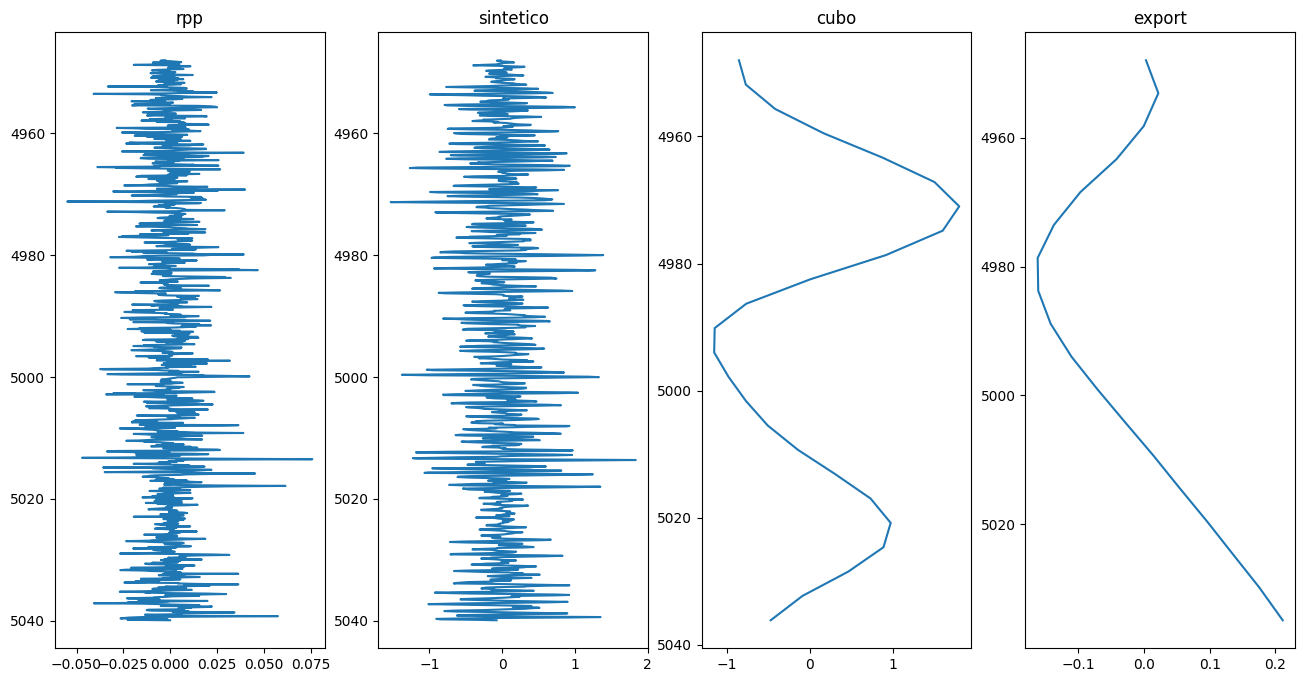

In [61]:
# synth18 = np.convolve(wvlt_15_2_30, Rpp18[:-1], mode = 'same') # wavelet_15_2_30
# synth18 = np.convolve(wvlt_90_20_probe, Rpp18[:-1], mode = 'same') # WAV_90_20_probe
synth18 = np.convolve(wvlt_sul_90, Rpp18[:-1], mode = 'same') # wavelet_area_menor_sul_90
# synth18 = np.convolve(wvlt_sinc_30_2_30, Rpp18[:-1], mode = 'same') # wavelet_sinc_30_2_30
# synth18 = np.convolve(wvlt_200_50, Rpp18[:-1], mode = 'same') # wavelet_200_50
# synth18 = np.convolve(wvlt_200_50_probe, Rpp18[:-1], mode = 'same') # wavelet_200_50_probe
# synth18 = np.convolve(wvlt_30_2_30, Rpp18[:-1], mode = 'same') # wav_30_2_30
# synth18 = np.convolve(wvlt_s_30_2_30, Rpp18[:-1], mode = 'same') # wav_s_30_2_30
# synth18 = np.convolve(wvlt_8_buz_20, Rpp18[:-1], mode = 'same') # wavelet_8_buz_20
# synth18 = np.convolve(wvlt_8_buz_20_25, Rpp18[:-1], mode = 'same') # wav_8-buz-20
csv18 = (seis18['TVDSS (m)'] > depth_point1) * (seis18['TVDSS (m)'] < depth_point2)
fig, axes = plt.subplots(1, 4, figsize = (16, 8))
zz = np.linspace(depth_point1, depth_point2, len(Rpp18) + 1)
axes[0].plot(Rpp18, zz[:-1]);
axes[0].invert_yaxis();
axes[0].set_title('rpp');
zz = np.linspace(depth_point1, depth_point2, synth18.shape[0] + 1)
axes[1].plot(synth18, zz[:-1]);
axes[1].invert_yaxis();
axes[1].set_title('sintetico');
zz = np.linspace(depth_point1, depth_point2, len(sismica18) + 1)
axes[2].plot(sismica18, zz[:-1]);
axes[2].invert_yaxis();
axes[2].set_title('cubo');
zz = np.linspace(depth_point1, depth_point2, sum(csv18) + 1)
axes[3].plot(seis18['Value'].loc[csv18].values, zz[:-1]);
axes[3].invert_yaxis();
axes[3].set_title('export');